In [94]:

polygon_points = [
    (0.5, 0.1), 
    (1.5, 0.2), 
    (1.1, 0.4)
    ]

In [95]:
import gmsh

# Initialize Gmsh
gmsh.initialize(["", "-bin"])
# gmsh.option.set("General.Terminal", 1)  # Uncomment to see output in terminal

# Step 1: Define the Geometry
gmsh.model.add("WindChannel")
mesh_size = 0.02

channel_length = 2.0
channel_height = 0.5
# Define Points (Corner Points of the Rectangle - Wind Channel)
p1 = gmsh.model.geo.addPoint(0.0, 0.0, 0.0, mesh_size)
p2 = gmsh.model.geo.addPoint(channel_length, 0.0, 0.0, mesh_size)
p3 = gmsh.model.geo.addPoint(channel_length, channel_height, 0.0, mesh_size)
p4 = gmsh.model.geo.addPoint(0.0, channel_height, 0.0, mesh_size)

#polygon_points = [(0.5, 0.1), (1.5, 0.2), (1.0, 0.4)]
# Define the Polygon (Triangular Polygon inside the channel)
# p5 = gmsh.model.geo.addPoint(0.5, 0.1, 0.0, mesh_size)
# p6 = gmsh.model.geo.addPoint(1.5, 0.1, 0.0, mesh_size)
# p7 = gmsh.model.geo.addPoint(1.0, 0.4, 0.0, mesh_size)
polygon_gmsh_points = [gmsh.model.geo.addPoint(x, y, 0.0, mesh_size) for x, y in polygon_points]

# Define Lines for the Wind Channel
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

# # Define Lines for the Polygon (Triangle)
# l5 = gmsh.model.geo.addLine(p5, p6)
# l6 = gmsh.model.geo.addLine(p6, p7)
# l7 = gmsh.model.geo.addLine(p7, p5)
polygon_lines = [gmsh.model.geo.addLine(polygon_gmsh_points[i], polygon_gmsh_points[(i+1)%len(polygon_gmsh_points)]) for i in range(len(polygon_gmsh_points))]

# Define Surface Loops
ll1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])  # Loop for the outer rectangle (wind channel)
ll2 = gmsh.model.geo.addCurveLoop(polygon_lines)      # Loop for the inner triangle (polygon)

# Define Plane Surfaces
s1 = gmsh.model.geo.addPlaneSurface([ll1, ll2])  # Surface for the wind channel with the polygon inside

# Step 2: Define the Mesh
# Synchronize to prepare for mesh generation
gmsh.model.geo.synchronize()

# Step 3: Mesh Generation
# Generate 2D mesh
gmsh.model.mesh.generate(2)

# Save the mesh to a binary file
gmsh.write("wind_channel.stl")

# Finalize Gmsh
gmsh.finalize()

import pyvista as pv
import numpy as np

grid=pv.read("wind_channel.stl")
points = grid.points
num_points = grid.number_of_points

grid.point_data["marker"]=np.zeros(num_points)

# set marker to 1 at inlet and outlet
grid.point_data["marker"][points[:,0]==0.0]=1
grid.point_data["marker"][points[:,0]==channel_length]=1


# set marker to 4 at all walls

# top and bottom walls
grid.point_data["marker"][points[:,1]==0.0]=4
grid.point_data["marker"][points[:,1]==channel_height]=4

# polygon walls

# find the points that are inside the polygon

from shapely.geometry import Polygon, Point
polygon = Polygon(polygon_points)
tolerance=1e-3
on_polygon = [polygon.dwithin(Point(x, y),tolerance) for x, y in points[:,:2]]
grid.point_data["marker"][on_polygon]=4

# for i in range(num_points):
#     p1 = (points[i,0], points[i,1])
#     j=(i+1)%num_points
#     p2 = (points[j,0], points[j,1])
#     points_on_lines = points
# polygon = Polygon(polygon_points)

for target in ["p","u","v"]:
    grid.point_data[target]=np.zeros(num_points)



grid.save("wind_channel.vtp")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.000484791s, CPU 0.000617s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0495439s, CPU 0.049287s)
Info    : 2814 nodes 5635 elements
Info    : Writing 'wind_channel.stl'...
Info    : Done writing 'wind_channel.stl'


/opt/homebrew/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


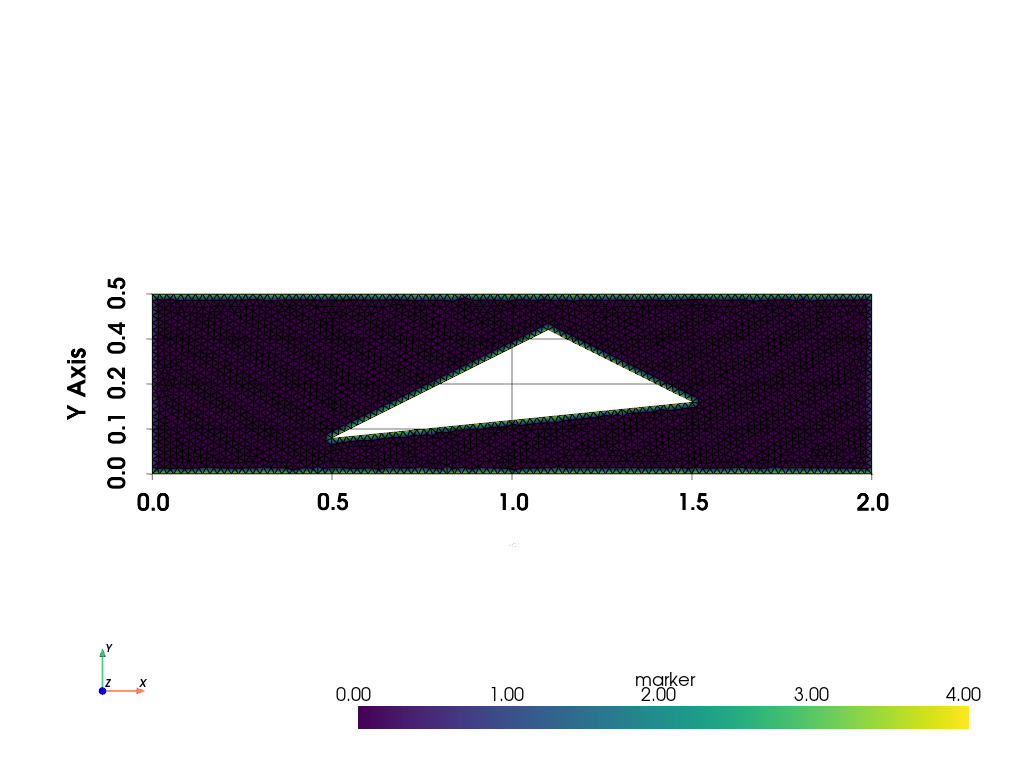

In [96]:
grid.plot(scalars="marker", show_edges=True, show_grid=True, notebook=True, cpos="xy")

In [97]:
grid

PolyData (0x34eef23e0)
  N Cells:    5270
  N Points:   2814
  N Strips:   0
  X Bounds:   0.000e+00, 2.000e+00
  Y Bounds:   0.000e+00, 5.000e-01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

In [98]:
import vtk
polydata = pv.read("wind_channel.vtp")
points = polydata.GetPoints()
vertices = np.array(
    [points.GetPoint(i) for i in range(points.GetNumberOfPoints())]
)

polys = polydata.GetPolys()
polys.InitTraversal()
edge_list = []
for i in range(polys.GetNumberOfCells()):
    id_list = vtk.vtkIdList()
    polys.GetNextCell(id_list)
    for j in range(id_list.GetNumberOfIds() - 1):
        edge_list.append(  # noqa: PERF401
            (id_list.GetId(j), id_list.GetId(j + 1))
        )

In [99]:
import dgl
import torch
graph=dgl.graph(edge_list)
graph = dgl.to_bidirected(graph)
graph.ndata["pos"] = torch.tensor(vertices[:, :2], dtype=torch.float32)

In [100]:
point_data = polydata.GetPointData()
marker = np.array(point_data.GetArray("marker"))
num_classes = 5
one_hot_marker = np.eye(num_classes)[marker.astype(int)]
graph.ndata["marker"] = torch.tensor(one_hot_marker, dtype=torch.float32)

In [101]:
graph

Graph(num_nodes=2814, num_edges=16168,
      ndata_schemes={'pos': Scheme(shape=(2,), dtype=torch.float32), 'marker': Scheme(shape=(5,), dtype=torch.float32)}
      edata_schemes={})

In [102]:
vertices, edge_list

(array([[1.82853174, 0.43782991, 0.        ],
        [1.84861469, 0.44835687, 0.        ],
        [1.82516146, 0.45781779, 0.        ],
        ...,
        [1.50173903, 0.17235322, 0.        ],
        [0.50885206, 0.06909716, 0.        ],
        [2.        , 0.36000001, 0.        ]]),
 [(0, 1),
  (1, 2),
  (3, 4),
  (4, 5),
  (6, 7),
  (7, 8),
  (9, 10),
  (10, 11),
  (12, 13),
  (13, 14),
  (15, 16),
  (16, 17),
  (18, 19),
  (19, 20),
  (21, 22),
  (22, 23),
  (24, 25),
  (25, 26),
  (27, 28),
  (28, 29),
  (30, 31),
  (31, 32),
  (32, 31),
  (31, 33),
  (25, 24),
  (24, 34),
  (35, 36),
  (36, 37),
  (38, 39),
  (39, 40),
  (41, 42),
  (42, 43),
  (44, 45),
  (45, 46),
  (47, 48),
  (48, 49),
  (4, 3),
  (3, 50),
  (51, 52),
  (52, 53),
  (28, 54),
  (54, 29),
  (55, 56),
  (56, 57),
  (58, 59),
  (59, 60),
  (61, 62),
  (62, 63),
  (64, 65),
  (65, 66),
  (52, 67),
  (67, 53),
  (68, 69),
  (69, 70),
  (1, 71),
  (71, 2),
  (36, 35),
  (35, 72),
  (65, 10),
  (10, 66),
  (13, 

In [103]:
polys.GetNumberOfCells()

5270